## Retrieve the data from the API

In [1]:
from csv import DictReader
from datetime import datetime

import pandas as pd
import requests
import seaborn
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

from ete3 import NCBITaxa
from matplotlib.gridspec import GridSpec

ete_db = NCBITaxa()

response = requests.get('https://www.ebi.ac.uk/eva/webservices/release/v2/stats/per-species')
response.raise_for_status()
release_metrics = response.json()

response = requests.get('https://www.ebi.ac.uk/eva/webservices/release/v1/info')
response.raise_for_status()
release_info = response.json()
version_to_date = {}
for release in release_info:
    version_to_date[release.get('releaseVersion')] = release['releaseDate'].split('T')[0]

/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Annotate the release metrics with release date and taxonomy lineage

In [51]:
def add_lineage_names(record_set):
    required_ranks = ['class']
    all_records = []
    for record in record_set:
        # Add information about lineage of the taxonomy
        lineage = ete_db.get_lineage(int(record.get('taxonomyId')))
        # Get the rank of each taxonomy ids
        ranks = ete_db.get_rank(lineage)
        # Get the taxonomy of the required ranks
        for required_rank in required_ranks:
            taxid_for_rank = [i for i in ranks if ranks[i] == required_rank]
            if taxid_for_rank:
                # Get the scientific names of the rank
                sci_name_of_required_rank = ete_db.get_taxid_translator(taxid_for_rank)[taxid_for_rank[0]]
                record[required_rank] = sci_name_of_required_rank
        all_records.append(record)
    return all_records
all_project_loaded = set()
for record in release_metrics:
    # Add date of the release
    record['releaseDate'] = version_to_date[record['releaseVersion']]
all_records = add_lineage_names(release_metrics)
df = pd.DataFrame.from_dict(all_records)
df['Date'] = pd.to_datetime(df['releaseDate'], format='%Y-%m-%d')


/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 563191 was translated into 187327
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 469587 was translated into 817
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/Users/tcezard/PycharmProjects/eva-tasks/venv/lib/python3.9/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 469586 was translated into 818
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))


## Only keep the relevant label from the class level

In [52]:
df['label'] = df['class']

# df.loc[df.superkingdom != 'Eukaryota', 'label'] = 'Others'

# Change all the label not in the list bellow to others
accepted_classes = {'Aves': 'Birds','Insecta':'Insects','Actinopteri': 'Fish','Mammalia': 'Mammals','Magnoliopsida': 'Flowering plants'}

# Check ~ which somehow means "NOT IN" in pandas
df.loc[~df['label'].isin(accepted_classes), 'label'] = 'Others'
df = df.replace({'label': accepted_classes})

df = df[df.label != 'Others']

# Group by class and releaseDate to add up all rs from a specific class
eva_metrics_per_class = df.groupby(['label', 'Date'])[["currentRs"]].sum().reset_index()
eva_metrics_per_class = eva_metrics_per_class.rename(columns={'currentRs': 'Reference SNP (rs)'})
eva_metrics_per_class


,label,Date,Reference SNP (rs)
0,Birds,2019-11-12,25515682
1,Birds,2020-11-03,25510830
2,Birds,2022-02-24,59854553
3,Birds,2022-11-21,60399128
4,Birds,2023-08-31,59933485
5,Birds,2024-07-08,97260706
6,Birds,2025-04-09,131211539
7,Fish,2019-11-12,18597026
8,Fish,2020-11-03,48087022
9,Fish,2022-02-24,55578268


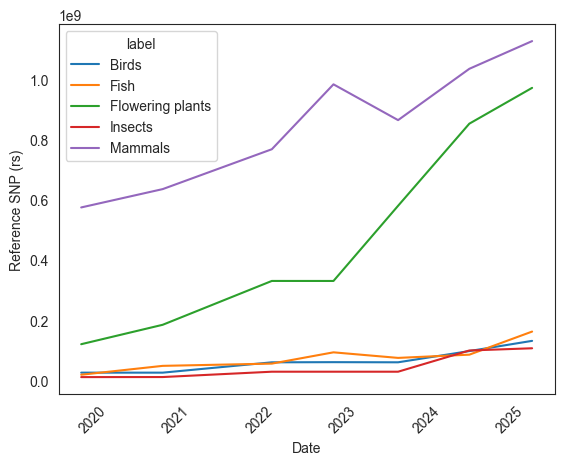

In [53]:
g2 = seaborn.lineplot(data=eva_metrics_per_class, x='Date', y='Reference SNP (rs)', hue='label')
g2.tick_params(axis='x', rotation=45)
g2.grid(False)

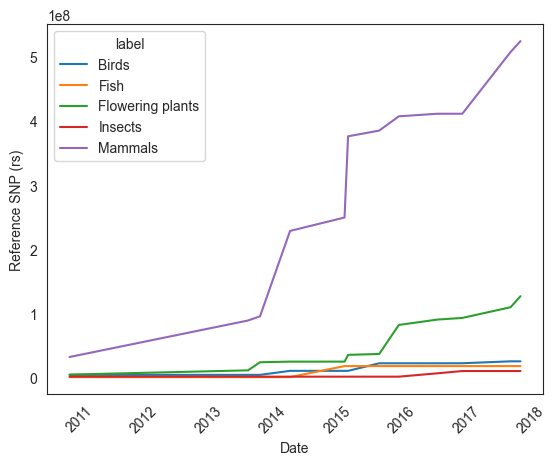

In [54]:

metrics = []
with open('dbsnp_non_human_builds.tsv') as open_file:
    reader = DictReader(open_file, delimiter='\t')
    for record in reader:
        name_translator = ete_db.get_name_translator([record.get('Organism')])
        record['taxonomyId'] = name_translator[record.get('Organism')][0]
        record['Reference SNP (rs)'] = int(record['Reference SNP (rs)'])
        metrics.append(record)

metrics = add_lineage_names(metrics)
df = pd.DataFrame(metrics)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date')
# df.loc(df['class'] == 'Magnoliopsida')
organism_info = df[['Organism', 'class', 'taxonomyId']].drop_duplicates().set_index('taxonomyId')

# Pivot the table: rows = dates, columns = organisms, values = Reference SNP (rs)
pivot_df = df.pivot(index='Date', columns='taxonomyId', values='Reference SNP (rs)')

# Forward fill missing values by organism (columns)
pivot_df_ffill = pivot_df.ffill()
pivot_df_ffill.fillna(0, inplace=True)
# Optionally, convert back to long format
filled_df = pivot_df_ffill.reset_index().melt(id_vars='Date', var_name='taxonomyId', value_name='Reference SNP (rs)')
filled_df = filled_df.merge(organism_info, left_on='taxonomyId', right_index=True, how='left')

filled_df = filled_df.sort_values(['Date', 'Organism']).reset_index(drop=True)

filled_df['label'] = filled_df['class']
#
# Change all the label not in the list bellow to others
accepted_classes = {'Aves': 'Birds','Insecta':'Insects','Actinopteri': 'Fish','Mammalia': 'Mammals','Magnoliopsida': 'Flowering plants'}
#
# Check ~ which somehow means "NOT IN" in pandas
filled_df.loc[~filled_df['label'].isin(accepted_classes), 'label'] = 'Others'
filled_df = filled_df.replace({'label': accepted_classes})

filled_df = filled_df[filled_df.label != 'Others']
# filled_df['Reference SNP (rs)'] = filled_df.groupby(['Organism'])['Reference SNP (rs)'].cumsum()
filled_df
# Group by class and releaseDate to add up all rs from a specific class
dbsnp_non_human_metrics = filled_df.groupby(['label', 'Date'])[["Reference SNP (rs)"]].sum().reset_index()
# dbsnp_non_human_metrics = dbsnp_non_human_metrics.loc[dbsnp_non_human_metrics['label'] == 'Flowering plants']
# dbsnp_non_human_metrics['Reference SNP (rs)'] = dbsnp_non_human_metrics['Reference SNP (rs)'] / 1000000000
g2 = seaborn.lineplot(data=dbsnp_non_human_metrics, x='Date', y='Reference SNP (rs)', hue='label')
g2.tick_params(axis='x', rotation=45)
g2.grid(False)

In [122]:
import matplotlib.pyplot as plt

dbsnp_human_metrics = pd.read_csv('dbsnp_human_release_metrics_per_year.tsv', sep='\t')
dbsnp_human_metrics['Date'] = pd.to_datetime(dbsnp_human_metrics['Year'], format='%Y')
dbsnp_human_metrics['label'] = 'Human'
dbsnp_human_metrics['source'] = 'dbSNP'
eva_metrics_per_class['source'] = 'EVA'
dbsnp_non_human_metrics['source'] = 'dbSNP'
eva_metrics_per_class = eva_metrics_per_class.loc[eva_metrics_per_class['label'] == 'Flowering plants']
dbsnp_non_human_metrics = dbsnp_non_human_metrics.loc[dbsnp_non_human_metrics['label'] == 'Flowering plants']

metrics = pd.concat([eva_metrics_per_class, dbsnp_human_metrics, dbsnp_non_human_metrics], axis='rows')
metrics['Reference SNP (rs)'] = metrics['Reference SNP (rs)'] / 1000000000
def line_plot_metrics(metrics, ax):
    seaborn.set_style('white')
    seaborn.lineplot(ax=ax, data=metrics, x='Date', y='Reference SNP (rs)', hue='label', style='source')
    ax.set(ylabel='Reference SNP (Billion)')
    ax.get_legend().remove()

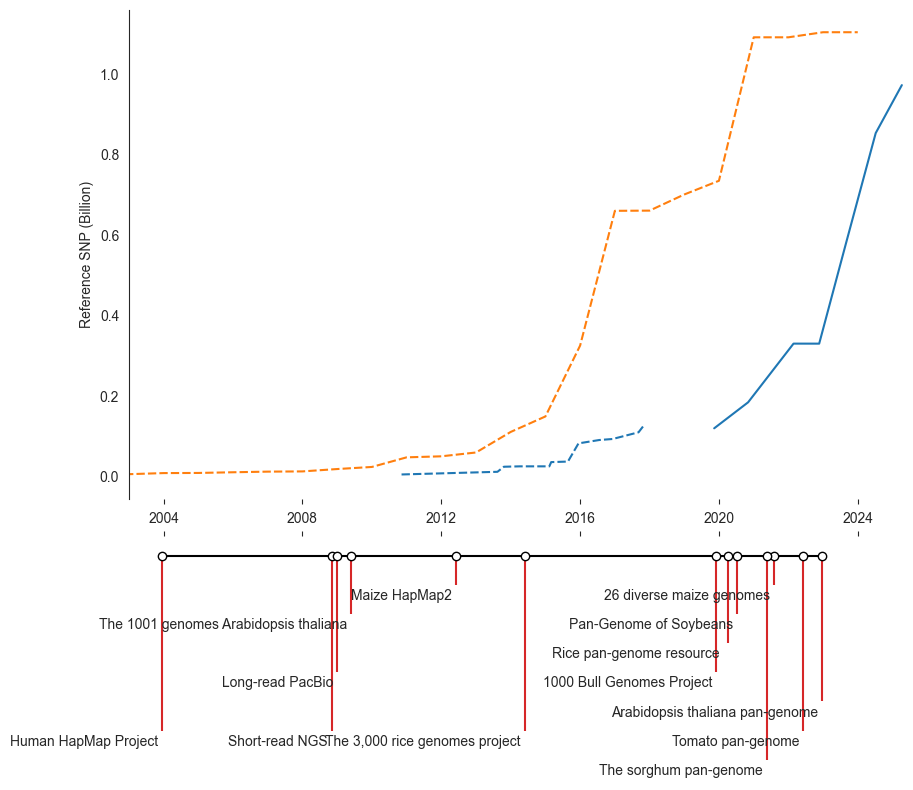

In [156]:

def plot_time_line(dates_labels_levels, fig, ax):
    dates = [d.get('date') for d in dates_labels_levels]
    levels = [d.get('level') for d in dates_labels_levels]
    ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
    ax.plot(dates, np.zeros_like(dates), "-o", color="k", markerfacecolor="w")  # Baseline and markers on it.

    # annotate lines
    for info_dict in dates_labels_levels:
        ax.annotate(info_dict.get('label'), xy=(info_dict.get('date'), info_dict.get('level')),
                    xytext=(-3, np.sign(info_dict.get('level'))*3), textcoords="offset points",
                    horizontalalignment="right",
                    verticalalignment="bottom" if info_dict.get('level') > 0 else "top")
    # remove y axis
    ax.yaxis.set_visible(False)

    ax.margins(y=0.1)
    plt.show()

dates_labels_levels = [
    {'level':-3, 'label': 'Human HapMap Project', 'date_str':'12/18/2003'},
    {'level':-3, 'label': 'Short-read NGS', 'date_str':'11/06/2008'},
    {'level':-2, 'label': 'Long-read PacBio', 'date_str':'01/02/2009'},
    {'level':-1, 'label': 'The 1001 genomes Arabidopsis thaliana', 'date_str':'5/27/2009'},
    {'level':-0.5, 'label': 'Maize HapMap2', 'date_str':'06/03/2012'},
    {'level':-3, 'label': 'The 3,000 rice genomes project', 'date_str':'5/28/2014'},
    {'level':-2, 'label': '1000 Bull Genomes Project', 'date_str':'12/03/2019'},
    {'level':-1.5, 'label': 'Rice pan-genome resource ', 'date_str':'04/07/2020'},
    {'level':-1, 'label': 'Pan-Genome of Soybeans', 'date_str':'07/09/2020'},
    {'level':-.5, 'label': '26 diverse maize genomes', 'date_str':'08/06/2021'},
    {'level':-3.5, 'label': 'The sorghum pan-genome', 'date_str':'5/20/2021'},
    {'level':-3, 'label': 'Tomato pan-genome', 'date_str':'06/08/2022'},
    {'level':-2.5, 'label': 'Arabidopsis thaliana pan-genome', 'date_str':'12/19/2022'}
]

for info_dict in dates_labels_levels:
    info_dict['date'] = datetime.strptime(info_dict['date_str'], '%m/%d/%Y')

fig = plt.figure(figsize=(10, 10))
start_date = datetime(2003, 1, 1)
end_date = datetime(2025, 5, 1)
gs = GridSpec(2, 1, height_ratios=[2, 1],  hspace=0.1)

# Top and bottom axes
ax_top = fig.add_subplot(gs[0])
ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)

# Hide the bottom x-axis of the top plot and the top x-axis of the bottom plot
ax_top.spines['top'].set_visible(False)
ax_top.spines['bottom'].set_visible(False)
ax_top.spines['right'].set_visible(False)
ax_top.tick_params(labelbottom=False, bottom=True)

ax_top.set_xlim(start_date, end_date)

# Move x-axis of bottom plot to top (between the plots)
ax_bottom.xaxis.set_ticks_position('top')

# Also move the actual spine (axis line)
ax_bottom.spines['top'].set_visible(True)
ax_bottom.spines['top'].set_position(('axes', 1.0))  # 1.0 means top of ax_bottom (between plots)
ax_bottom.spines[["left", "top", "right", "bottom"]].set_visible(False)


line_plot_metrics(metrics, ax_top)
plot_time_line(dates_labels_levels, fig, ax_bottom)
